# Database Construction
---
#### 1. Construct database for seismic and infrasound data extraction
#### 2. Plot event locations, magnitudes, and source-receiver distances
#### 3. Plot seismoacoustic array coordinates
#### 4. Read and augment seismic and infrasound data
---
#### File paths represent those used in the study.
#### Users will have to be sure file paths match where they stored the data/spreadsheets.

In [1]:
%%time
import warnings, random
#-----------------------------------------------------------------------------------------------------------------------#
import numpy as np
import pandas as pd
import koreageonet_v1 as KGN
#-----------------------------------------------------------------------------------------------------------------------#
from tensorflow.keras import *
from obspy import UTCDateTime, read
from sklearn.model_selection import StratifiedKFold

CPU times: user 9.27 s, sys: 9.5 s, total: 18.8 s
Wall time: 55.5 s


## Surface Explosions Database
---

In [71]:
%%time
# Read surface explosions file from KIGAM
df = pd.read_csv('Spreadsheets/Surface_Explosion_Events.txt', delim_whitespace=True, skiprows=1, header=None)
#-----------------------------------------------------------------------------------------------------------------------#
# Construct database
KGN.construct_database(dates=df[4], times=df[5], lats=df[1], lons=df[2], mags=df[6], celerity_range=[0.225, 0.400], database_type='explosions')

Building obspy.taup model for 'kigam.tvel' ...
filename = kigam.tvel
Done reading velocity model.
Radius of model  is 6371.0
Using parameters provided in TauP_config.ini (or defaults if not) to call SlownessModel...
Parameters are:
taup.create.min_delta_p = 0.1 sec / radian
taup.create.max_delta_p = 11.0 sec / radian
taup.create.max_depth_interval = 115.0 kilometers
taup.create.max_range_interval = 0.04363323129985824 degrees
taup.create.max_interp_error = 0.05 seconds
taup.create.allow_inner_core_s = True
Slow model  529 P layers,572 S layers
Done calculating Tau branches.
Done Saving /Users/mronacgiannone/anaconda3/envs/koreageonet/lib/python3.11/site-packages/obspy/taup/data/kigam.npz
Method run is done, but not necessarily successful.
Done saving database.
CPU times: user 33 s, sys: 505 ms, total: 33.5 s
Wall time: 33.5 s


In [16]:
# Visualize database
df_exp = pd.read_excel('Spreadsheets/Surface_Explosions_Database.xlsx', skiprows=0, header=0)
print('Number of events: '+str(len(df_exp))); df_exp.head()

Number of events: 795


,Event Date/Time,Event Latitude,Event Longitude,Event Magnitude (ML),BRD Distance (km),CHN Distance (km),KSG Distance (km),BRD Baz,CHN Baz,KSG Baz,...,CHN Seismic Starttime (s),CHN Seismic Endtime (s),KSG Seismic Starttime (s),KSG Seismic Endtime (s),BRD Infrasound Starttime (s),BRD Infrasound Endtime (s),CHN Infrasound Starttime (s),CHN Infrasound Endtime (s),KSG Infrasound Starttime (s),KSG Infrasound Endtime (s)
0,2012/01/02 02:54:49,37.56,128.95,1.4,380.60,179.19,126.76,95.62,115.97,155.41,...,19.06,149.06,10.87,140.87,951.50,1691.55,447.96,796.38,316.90,563.37
1,2012/01/02 04:28:27,39.34,127.36,1.2,279.79,119.74,119.30,56.24,9.67,314.16,...,9.71,139.71,9.64,139.64,699.47,1243.50,299.35,532.17,298.24,530.21
2,2012/01/03 04:25:57,39.37,127.24,1.6,273.69,122.34,129.15,54.46,4.83,312.42,...,10.14,140.14,11.26,141.26,684.22,1216.38,305.86,543.75,322.87,573.98
3,2012/01/05 03:28:11,38.82,126.10,1.7,157.39,107.95,197.43,52.60,304.44,278.03,...,7.77,137.77,21.39,151.39,393.47,699.51,269.88,479.79,493.57,877.46
4,2012/01/09 03:12:23,38.88,126.11,1.6,162.18,110.77,197.17,51.00,307.53,279.93,...,8.23,138.23,21.36,151.36,405.45,720.80,276.92,492.30,492.93,876.31


<IPython.core.display.Javascript object>


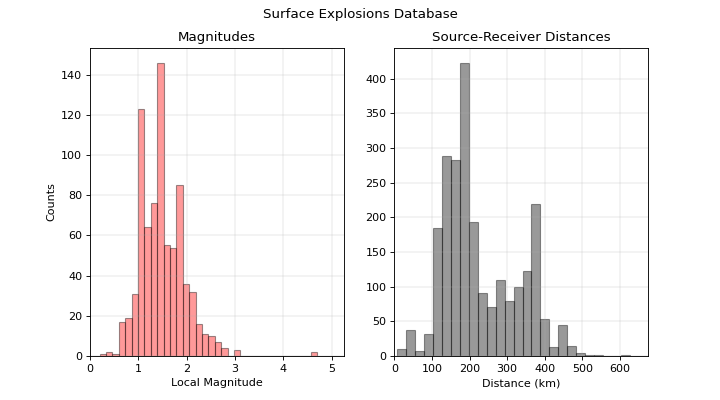

In [17]:
%matplotlib notebook
# Retrieving mags and dists
mags = df_exp['Event Magnitude (ML)'].values
dists = np.concatenate((df_exp['BRD Distance (km)'].values, df_exp['CHN Distance (km)'].values, df_exp['KSG Distance (km)'].values))
#-----------------------------------------------------------------------------------------------------------------------#
# Plotting histogram
mags_xlim = [0,5.25]; dists_xlim = [0,675]
bins_mags, bins_dists = KGN.plot_hist([mags], [dists], return_bins=True, mags_xlim=mags_xlim, dists_xlim=dists_xlim, title='Surface Explosions Database')

In [18]:
print('Explosion average distance and std is: ' + str(dists.mean()) + ' ' + str(dists.std()))

Explosion average distance and std is: 226.60190356394128 101.16577049069524


## Earthquakes Database
---

In [74]:
%%time
# Read earthquakes file from KMA
df = pd.read_excel('Spreadsheets/Earthquake_Events.xlsx', skiprows=0, header=0)
#-----------------------------------------------------------------------------------------------------------------------#
# Need Korean column labels
korean_cols = []
for col in df:
    korean_cols.append(col)
#-----------------------------------------------------------------------------------------------------------------------#
# Modify inputs for database function
dates = []; times = []; lats = []; lons = []; mags = []
for idx in range(len(df[korean_cols[0]])):
    dates.append(str((UTCDateTime(df[korean_cols[0]][idx]).replace(microsecond=0)-(3600*9)).isoformat(' ')).split(' ')[0].replace('-','/'))
    times.append(str((UTCDateTime(df[korean_cols[0]][idx]).replace(microsecond=0)-(3600*9)).isoformat(' ')).split(' ')[1].replace('-','/'))
    lats.append(float(df[korean_cols[2]][idx].replace('N',''))); lons.append(float(df[korean_cols[3]][idx].replace('E','')))
    mags.append(df[korean_cols[1]][idx])
#-----------------------------------------------------------------------------------------------------------------------#
# Construct database
KGN.construct_database(dates=dates, times=times, lats=lats, lons=lons, mags=mags, celerity_range=[0.225, 0.400], database_type='earthquakes')

Building obspy.taup model for 'kigam.tvel' ...
filename = kigam.tvel
Done reading velocity model.
Radius of model  is 6371.0
Using parameters provided in TauP_config.ini (or defaults if not) to call SlownessModel...
Parameters are:
taup.create.min_delta_p = 0.1 sec / radian
taup.create.max_delta_p = 11.0 sec / radian
taup.create.max_depth_interval = 115.0 kilometers
taup.create.max_range_interval = 0.04363323129985824 degrees
taup.create.max_interp_error = 0.05 seconds
taup.create.allow_inner_core_s = True
Slow model  529 P layers,572 S layers
Done calculating Tau branches.
Done Saving /Users/mronacgiannone/anaconda3/envs/koreageonet/lib/python3.11/site-packages/obspy/taup/data/kigam.npz
Method run is done, but not necessarily successful.
Done saving database.
CPU times: user 29.2 s, sys: 428 ms, total: 29.6 s
Wall time: 29.6 s


In [11]:
# Visualize database
df_eq = pd.read_excel('Spreadsheets/Earthquakes_Database.xlsx', skiprows=0, header=0)
print('Number of events: '+str(len(df_eq))); df_eq.head()

Number of events: 721


,Event Date/Time,Event Latitude,Event Longitude,Event Magnitude (ML),BRD Distance (km),CHN Distance (km),KSG Distance (km),BRD Baz,CHN Baz,KSG Baz,...,CHN Seismic Starttime (s),CHN Seismic Endtime (s),KSG Seismic Starttime (s),KSG Seismic Endtime (s),BRD Infrasound Starttime (s),BRD Infrasound Endtime (s),CHN Infrasound Starttime (s),CHN Infrasound Endtime (s),KSG Infrasound Starttime (s),KSG Infrasound Endtime (s)
0,2012/01/01 10:40:31,39.02,125.82,2.0,154.73,140.07,224.40,40.71,306.53,282.94,...,13.06,143.06,24.83,154.83,386.83,687.69,350.18,622.53,561.00,997.34
1,2012/01/15 18:03:54,36.79,128.75,2.2,385.13,218.94,203.78,108.68,138.56,169.98,...,24.14,154.14,22.20,152.20,962.82,1711.69,547.35,973.06,509.46,905.70
2,2012/01/19 06:43:00,38.51,126.23,2.7,150.29,82.00,184.76,66.01,288.67,267.72,...,3.50,133.50,19.77,149.77,375.73,667.96,204.99,364.43,461.89,821.14
3,2012/01/23 17:41:53,37.12,125.96,2.2,149.17,164.39,266.46,128.97,218.84,232.74,...,17.06,147.06,30.20,160.20,372.92,662.97,410.98,730.64,666.15,1184.27
4,2012/02/19 11:21:29,35.13,129.89,2.7,564.40,428.12,408.89,122.44,143.98,159.98,...,50.77,180.77,48.33,178.33,1411.00,2508.44,1070.30,1902.76,1022.23,1817.29


<IPython.core.display.Javascript object>


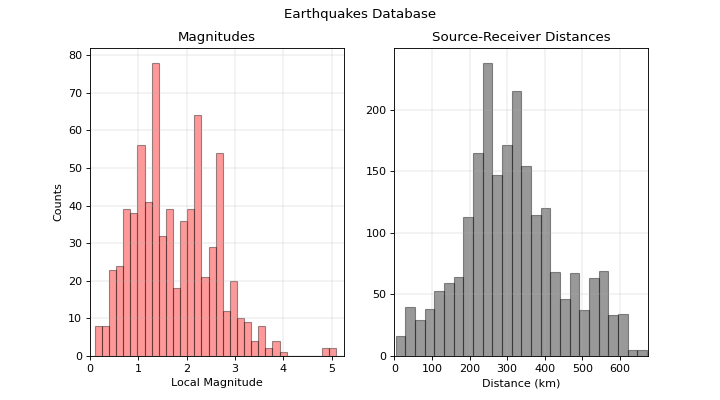

In [12]:
%matplotlib notebook
# Retrieving mags and dists
mags = df_eq['Event Magnitude (ML)'].values
dists = np.concatenate((df_eq['BRD Distance (km)'].values, df_eq['CHN Distance (km)'].values, df_eq['KSG Distance (km)'].values))
#-----------------------------------------------------------------------------------------------------------------------#
# Plotting
KGN.plot_hist([mags], [dists], bins_mags=bins_mags, bins_dists=bins_dists, mags_xlim=mags_xlim, dists_xlim=dists_xlim, title='Earthquakes Database')

In [14]:
print('Earthquake average distance and std is: ' + str(dists.mean()) + ' ' + str(dists.std()))

Earthquake average distance and std is: 312.97338418862694 131.5390678385524


## Generating map
---

<IPython.core.display.Javascript object>


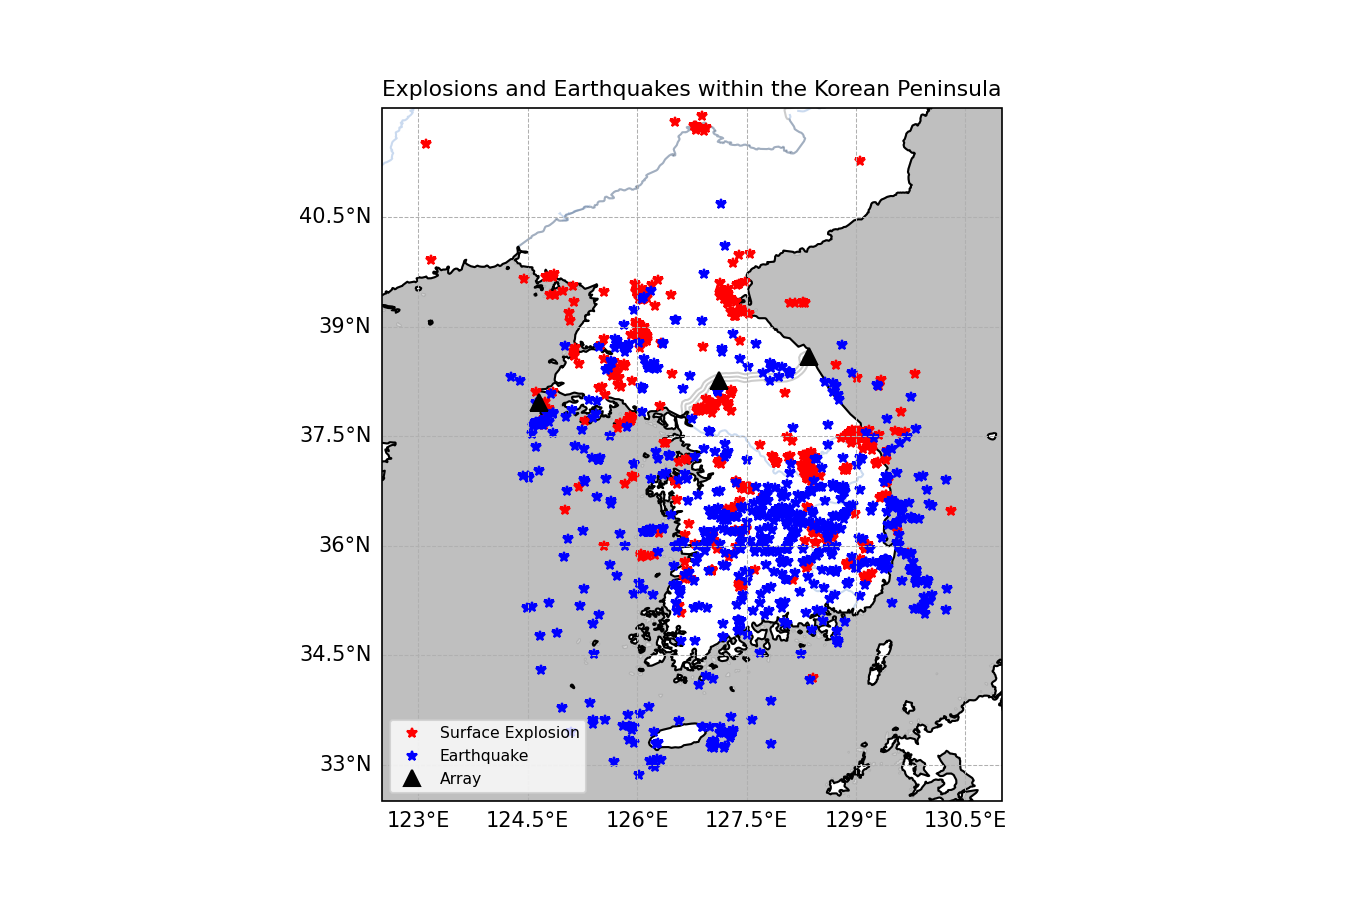

In [5]:
%matplotlib notebook
KGN.generate_map(df_eq['Event Latitude'], df_eq['Event Longitude'], df_exp['Event Latitude'], df_exp['Event Longitude'])

## Plotting seismoacoustic array coordinates
---
#### Appending seismic location info

In [6]:
# Convert database dates to JD for easy indexing
df_eq = KGN.convert_database_datetimes_to_JD('Spreadsheets/Earthquakes_Database.xlsx')
# Choosing arbitrary day and channel for appending seismic location data
event_type='Earthquake'; year='2013'; day='156'; time='03:34:12'; channel='BHZ'
#-----------------------------------------------------------------------------------------------------------------------#
# BRD
st_brd = read('/Volumes/Extreme SSD/Korea_Events/'+event_type+'s/Seismic/Waveforms/BRD/'+year+'_'+day+'_'+time.replace(':','-')+'.mseed')
df_brd = pd.read_table('Korea_Array_Locations/BRDAR_Seismic_Locations', header=None, sep='\s+', names=['stn', 'lat', 'lon'])
st_brd = KGN.append_loc_info(st_brd, df_brd, array='BRD')
#-----------------------------------------------------------------------------------------------------------------------#
# CHN
st_chn = read('/Volumes/Extreme SSD/Korea_Events/'+event_type+'s/Seismic/Waveforms/CHN/'+year+'_'+day+'_'+time.replace(':','-')+'.mseed')
df_chn = pd.read_table('Korea_Array_Locations/CHNAR_Seismic_Locations', header=None, sep='\s+', names=['stn', 'lat', 'lon'])
st_chn = KGN.append_loc_info(st_chn, df_chn, array='CHN')
#-----------------------------------------------------------------------------------------------------------------------#
# KSG
st_ksg = read('/Volumes/Extreme SSD/Korea_Events/'+event_type+'s/Seismic/Waveforms/KSG/'+year+'_'+day+'_'+time.replace(':','-')+'.mseed')
df_ksg = pd.read_table('Korea_Array_Locations/KSGAR_Seismic_Locations', header=None, sep='\s+', names=['stn', 'lat', 'lon'])
st_ksg = KGN.append_loc_info(st_ksg, df_ksg, array='KSG')

---
#### Appending infrasound location info

In [7]:
# Now append infrasound location info
infra_date = '2012/002 02:54:49'
#-----------------------------------------------------------------------------------------------------------------------#
# BRD
directory_wavf = '/Volumes/Extreme SSD/Korea_Events/Explosions/Infrasound/Waveforms/BRD'
st_brd_infra = read(directory_wavf+'/'+infra_date.replace('/','_').replace(' ','_').replace(':','-')+'.mseed')
df_brd = pd.read_table('Korea_Array_Locations/BRDAR_Infrasound_Locations', header=None, sep='\s+', names=['stn', 'lat', 'lon'])
st_brd_infra = KGN.append_loc_info(st_brd_infra, df_brd, array='BRD')
#-----------------------------------------------------------------------------------------------------------------------#
# CHN
directory_wavf = '/Volumes/Extreme SSD/Korea_Events/Explosions/Infrasound/Waveforms/CHN'
st_chn_infra = read(directory_wavf+'/'+infra_date.replace('/','_').replace(' ','_').replace(':','-')+'.mseed')
df_chn = pd.read_table('Korea_Array_Locations/CHNAR_Infrasound_Locations', header=None, sep='\s+', names=['stn', 'lat', 'lon'])
st_chn_infra = KGN.append_loc_info(st_chn_infra, df_chn, array='CHN')
#-----------------------------------------------------------------------------------------------------------------------#
# KSG
directory_wavf = '/Volumes/Extreme SSD/Korea_Events/Explosions/Infrasound/Waveforms/KSG'
st_ksg_infra = read(directory_wavf+'/'+infra_date.replace('/','_').replace(' ','_').replace(':','-')+'.mseed')
df_ksg = pd.read_table('Korea_Array_Locations/KSGAR_Infrasound_Locations', header=None, sep='\s+', names=['stn', 'lat', 'lon'])
st_ksg_infra = KGN.append_loc_info(st_ksg_infra, df_ksg, array='KSG')

---
#### Plotting

<IPython.core.display.Javascript object>


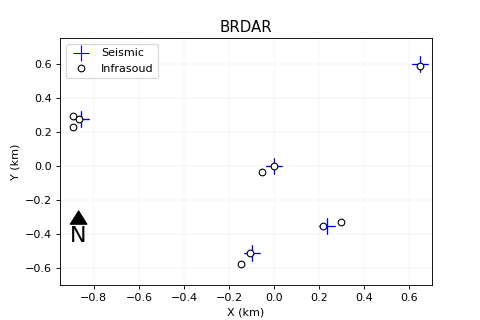

In [24]:
%matplotlib notebook
X, stnm = KGN.plot_seismoacoustic_array_coords(st_brd, st_brd_infra, st_brd[3].stats.station, infra_ref_idx=0, kilometers=True, array='BRDAR', figsize=(6,4), xlim=[-0.95,0.7], ylim=[-0.7,0.75], 
                                               title_fontsize=13.5, markerscale=1, legend_loc='upper left')

<IPython.core.display.Javascript object>


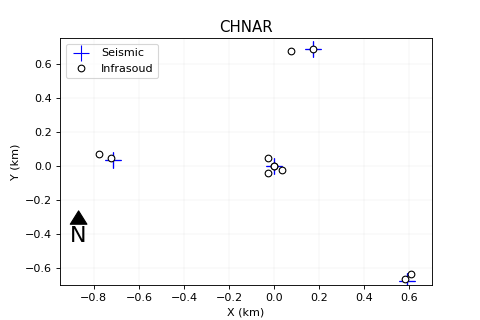

In [23]:
%matplotlib notebook
X, stnm = KGN.plot_seismoacoustic_array_coords(st_chn, st_chn_infra, st_chn[0].stats.station, infra_ref_idx=0, kilometers=True, array='CHNAR', figsize=(6,4), xlim=[-0.95,0.7], ylim=[-0.7,0.75], 
                                               title_fontsize=13.5, markerscale=1, legend_loc='upper left')

<IPython.core.display.Javascript object>


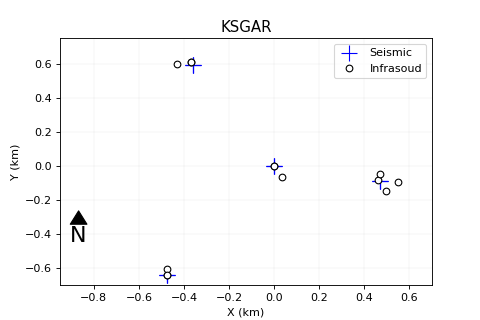

In [22]:
%matplotlib notebook
X, stnm = KGN.plot_seismoacoustic_array_coords(st_ksg, st_ksg_infra, st_ksg[0].stats.station, infra_ref_idx=2, kilometers=True, array='KSGAR', figsize=(6,4), xlim=[-0.95,0.7], ylim=[-0.7,0.75], 
                                               title_fontsize=13.5, markerscale=1, legend_loc='upper right')

## Han et al. 2023 Catalog
---

In [193]:
df_skr = pd.read_csv('Spreadsheets/KR10yr_EQ_catalog.csv', delim_whitespace=False, skiprows=0, header=0)
df_skr

,pick,utc0,lat0,lon0,dep0,utc,lat,lon,dep,mag,etype1,geomean,rf_label,rf_prob
0,2012E000000000,2012-01-01T22:33:56.450000Z,35.6906,129.3669,10.01,2012-01-01T22:33:56.700000Z,35.6930,129.3623,8.84,0.4585,EQ,0.3973,NaN,NaN
1,2012E000000001,2012-01-02T03:07:03.300000Z,36.5103,127.2509,3.91,2012-01-02T03:07:03.560000Z,36.5094,127.2490,0.04,1.2191,Exp,0.9997,NaN,NaN
2,2012E000000002,2012-01-02T06:37:21.690000Z,37.2616,128.3200,3.16,2012-01-02T06:37:21.840000Z,37.2626,128.3104,3.74,0.8991,Exp,0.9222,NaN,NaN
3,2012E000000003,2012-01-02T07:23:56.430000Z,37.2282,128.3637,2.71,2012-01-02T07:23:56.640000Z,37.2274,128.3610,0.58,0.8377,Exp,0.8401,NaN,NaN
4,2012E000000004,2012-01-02T07:46:58.780000Z,35.9747,129.5610,8.36,2012-01-02T07:46:58.830000Z,35.9724,129.5695,11.06,1.4434,EQ,0.1352,B,0.0083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66853,2021E001768300,2021-12-31T13:43:04.720000Z,35.8420,129.6775,20.32,2021-12-31T13:43:04.310000Z,35.8315,129.7091,19.28,0.9601,EQ,0.0062,B,0.0167
66854,2021E001768301,2021-12-31T17:05:03.580000Z,35.4032,128.5766,13.50,2021-12-31T17:05:03.800000Z,35.4021,128.5786,11.67,1.2059,EQ,0.0000,B,0.2750
66855,2021E001768302,2021-12-31T17:38:34.850000Z,35.4011,128.5728,12.41,2021-12-31T17:38:35.070000Z,35.4005,128.5762,11.02,0.7402,EQ,0.0000,A,0.9583
66856,2021E001768303,2021-12-31T17:54:30.410000Z,35.7735,129.1989,13.84,2021-12-31T17:54:30.600000Z,35.7659,129.1976,14.43,0.6085,EQ,0.0000,B,0.2968


In [192]:
df_skr = pd.read_csv('Spreadsheets/KR10yr_EQ_catalog_RemovedTo2017.csv', delim_whitespace=False, skiprows=0, header=0)
df_new = df_skr.loc[(df_skr.etype1 == 'EQ') & (df_skr.mag >= 1.5) & (df_skr.lat >= 37) & (df_skr.dep <= 10)].reset_index()
df_new

,index,pick,utc0,lat0,lon0,dep0,utc,lat,lon,dep,mag,etype1,geomean,rf_label,rf_prob
0,416,2016E000053533,2016-10-12T23:56:30.360000Z,38.3947,128.0863,1.20,2016-10-12T23:56:30.520000Z,38.3933,128.0938,0.10,2.2773,EQ,0.0749,B,0.4667
1,438,2016E000053555,2016-10-13T13:50:40.670000Z,37.3511,129.3871,11.01,2016-10-13T13:50:40.790000Z,37.3526,129.3843,9.83,1.5039,EQ,0.0002,B,0.1750
2,530,2016E000053647,2016-10-16T15:42:29.210000Z,37.9231,124.6631,10.99,2016-10-16T15:42:29.350000Z,37.9242,124.6699,9.99,2.1427,EQ,0.0007,B,0.1750
3,629,2016E000053746,2016-10-19T10:00:03.830000Z,37.0613,129.5735,5.67,2016-10-19T10:00:03.900000Z,37.0658,129.5758,5.01,1.5729,EQ,0.3778,B,0.2500
4,684,2016E000053802,2016-10-21T16:00:52.570000Z,37.9978,128.8622,8.17,2016-10-21T16:00:52.800000Z,37.8585,128.6236,9.48,1.5210,EQ,0.0000,B,0.1250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45879,2021E001766697,2021-11-01T18:27:14.140000Z,37.1878,129.0712,0.06,2021-11-01T18:27:14.090000Z,37.1939,129.0872,0.10,1.5286,EQ,0.0033,B,0.1417
299,45936,2021E001766755,2021-11-04T00:04:08.520000Z,37.0231,126.0353,3.74,2021-11-04T00:04:08.510000Z,37.0192,126.0178,0.10,1.6087,EQ,0.0110,A,0.6583
300,46278,2021E001767105,2021-11-17T00:50:27.600000Z,37.8440,129.1934,3.16,2021-11-17T00:50:26.930000Z,37.8574,129.2493,2.61,1.5142,EQ,0.3208,B,0.0750
301,46752,2021E001767584,2021-12-04T22:47:03.470000Z,37.1898,129.0805,2.16,2021-12-04T22:47:03.440000Z,37.1934,129.1038,0.10,2.2772,EQ,0.3515,B,0.4333


In [37]:
# Need to convert dates and times in Han 2023 database
dates = df_new.utc.copy(); times = dates.copy()
for eq_idx in range(len(df_new)):    
    dates[eq_idx] = df_new.utc[eq_idx].split('T')[0].replace('-','/')
    times[eq_idx] = df_new.utc[eq_idx].split('T')[1][:8]

In [38]:
# Construct database
KGN.construct_database(dates=dates, times=times, lats=df_new.lat, lons=df_new.lon, mags=df_new.mag, celerity_range=[0.225, 0.400], database_type='Han2023_Earthquakes_Database')

Building obspy.taup model for 'kigam.tvel' ...
filename = kigam.tvel
Done reading velocity model.
Radius of model  is 6371.0
Using parameters provided in TauP_config.ini (or defaults if not) to call SlownessModel...
Parameters are:
taup.create.min_delta_p = 0.1 sec / radian
taup.create.max_delta_p = 11.0 sec / radian
taup.create.max_depth_interval = 115.0 kilometers
taup.create.max_range_interval = 0.04363323129985824 degrees
taup.create.max_interp_error = 0.05 seconds
taup.create.allow_inner_core_s = True
Slow model  529 P layers,572 S layers
Done calculating Tau branches.
Done Saving /Users/mronacgiannone/anaconda3/envs/koreageonet/lib/python3.11/site-packages/obspy/taup/data/kigam.npz
Method run is done, but not necessarily successful.
Done saving database.


## Extract waveforms from each of the databases
---
#### Filter and store data

In [7]:
%%time
# Earthquakes - storing stn labels for plotting purposes
data_eq, metadata_eq, stn_labels_eq = KGN.get_event_waveforms('Spreadsheets/Earthquakes_Seismic_Detections.xlsx', ['Spreadsheets/Earthquakes_Database.xlsx', 'Spreadsheets/Han2023_Earthquakes_Database.xlsx'], event_type='Earthquake', 
                                                              freqmin=1, freqmax=10)

There are 1205 total detections with shape: (1205, 3, 5201, 3)
CPU times: user 8.25 s, sys: 552 ms, total: 8.8 s
Wall time: 8.81 s


In [8]:
%%time
# Explosions
data_exp, metadata_exp, stn_labels_exp = KGN.get_event_waveforms('Spreadsheets/Surface_Explosions_Seismic_Detections.xlsx', ['Spreadsheets/Surface_Explosions_Database.xlsx'], event_type='Explosion', freqmin=1, freqmax=10)

There are 993 total detections with shape: (993, 3, 5201, 3)
CPU times: user 6.63 s, sys: 610 ms, total: 7.24 s
Wall time: 8.04 s


In [9]:
%%time
save_eq_data = False
if save_eq_data == True:
    np.save('/Volumes/Extreme SSD/Korea_Events/Earthquakes/seismic_data_eq.npy',data_eq)
    np.save('/Volumes/Extreme SSD/Korea_Events/Earthquakes/metadata_eq.npy',metadata_eq)
    np.save('/Volumes/Extreme SSD/Korea_Events/Earthquakes/stn_labels_eq.npy',stn_labels_eq)

CPU times: user 5.06 ms, sys: 153 ms, total: 158 ms
Wall time: 495 ms


In [10]:
%%time
save_exp_data = False
if save_exp_data == True:
    np.save('/Volumes/Extreme SSD/Korea_Events/Explosions/seismic_data_exp.npy',data_exp)
    np.save('/Volumes/Extreme SSD/Korea_Events/Explosions/metadata_exp.npy',metadata_exp)
    np.save('/Volumes/Extreme SSD/Korea_Events/Explosions/stn_labels_exp.npy',stn_labels_exp)

CPU times: user 4.74 ms, sys: 111 ms, total: 116 ms
Wall time: 412 ms


## Augment data
---
#### Load seismic data vectors

In [2]:
%%time
# Earthquakes
data_eq = np.load('/Volumes/Extreme SSD/Korea_Events/Earthquakes/seismic_data_eq.npy')
metadata_eq = np.load('/Volumes/Extreme SSD/Korea_Events/Earthquakes/metadata_eq.npy')
#-----------------------------------------------------------------------------------------------------------------------#
# Explosions
data_exp = np.load('/Volumes/Extreme SSD/Korea_Events/Explosions/seismic_data_exp.npy')
metadata_exp = np.load('/Volumes/Extreme SSD/Korea_Events/Explosions/metadata_exp.npy')

CPU times: user 2.15 ms, sys: 317 ms, total: 319 ms
Wall time: 958 ms


---
#### Construct training labels and concatenate seismic data

In [3]:
%%time
# Making one-hot-encoded labels (0 = earthquake, 1 = explosion)
y_exp = np.full(len(data_exp),1)
y_eq = np.full(len(data_eq),0)
y = np.concatenate((y_exp, y_eq))
y_ohe = utils.to_categorical(y.astype('int64'))
#-----------------------------------------------------------------------------------------------------------------------#
# Now let's merge the waveform data and event metadata
X = np.concatenate((data_exp, data_eq))
event_metadata = np.concatenate((metadata_exp, metadata_eq)) # event type, array, lat, lon, mag, dist

CPU times: user 97.1 ms, sys: 243 ms, total: 340 ms
Wall time: 603 ms


---
#### Augment datasets 6x - store train/test sets

In [4]:
# Precompute augmentations
n_splits = 5; split = 0; save = True
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
for train_index, test_index in kfold.split(X, y):
    print('Begin split # ' +str(split+1) + ' of '+ str(n_splits))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_ohe[train_index], y_ohe[test_index]
    ev_metadata_train, ev_metadata_test = event_metadata[train_index], event_metadata[test_index]
    #-----------------------------------------------------------------------------------------------------------------------#
    # Get infrasound data
    print('Retrieving epicentral infrasound data')
    X_train_infra, X_train_infra_T, X_test_infra, X_test_infra_T = KGN.get_TrainTest_infrasound_data(ev_metadata_train, ev_metadata_test, 
                                                                                                     eq_database_filename='Spreadsheets/Infra/Earthquakes_Database.xlsx', 
                                                                                                     exp_database_filename='Spreadsheets/Infra/Surface_Explosions_Database.xlsx', 
                                                                                                     resize=True, npts_freq=10, npts_time=200, azimuth_deviation=True)
    #-----------------------------------------------------------------------------------------------------------------------#
    # Augment data
    print('Starting epicentral infrasound data augmentation')
    # Epicentral infrasound
    X_train_infra_aug, X_test_infra_ss = KGN.augment_infrasound_training_data(X_train_infra, X_train_infra_T, X_test_infra, max_timeshift=5, augmentations=6, add_random_noise=True, std_noise_percent=5)
    print('Starting seismic data augmentation')
    # Augmenting training dataset (not returning waveforms)
    _, X_train_spec, _, X_test_spec, y_train_aug = KGN.augment_seismic_training_data(X_train, X_test, y_train, spec_win_overlap=0.7, samp_rate=40, win_len=90, randomly_reorder_stations=True,
                                                                                        augmentations=6, add_random_noise=True, max_timeshift=5, var_noise_percent=5) # spread of random Gaussian noise is 5% of variance (by trace)
    # Randomly shuffle augmented training data 
    random_train_aug_segments_idx = random.sample(range(X_train_spec.shape[0]), X_train_spec.shape[0])
    X_train_spec = X_train_spec[random_train_aug_segments_idx,:,:,:]
    X_train_infra_aug = X_train_infra_aug[random_train_aug_segments_idx,:,:,:]
    y_train_aug = y_train_aug[random_train_aug_segments_idx,:]
    print('Finished data augmentation')
    #-----------------------------------------------------------------------------------------------------------------------#
    # Storing train sets
    if save == True:
        np.save('/Volumes/Extreme SSD/Korea_Events/Train_Data/6x/Split_'+str(split+1)+'/X_seismic.npy',X_train_spec)
        np.save('/Volumes/Extreme SSD/Korea_Events/Train_Data/6x/Split_'+str(split+1)+'/X_infra.npy',X_train_infra_aug)
        np.save('/Volumes/Extreme SSD/Korea_Events/Train_Data/6x/Split_'+str(split+1)+'/y.npy',y_train_aug)
    # Storing test sets
    if save == True:
        np.save('/Volumes/Extreme SSD/Korea_Events/Test_Data/Split_'+str(split+1)+'/X_seismic.npy',X_test_spec)
        np.save('/Volumes/Extreme SSD/Korea_Events/Test_Data/Split_'+str(split+1)+'/X_infra.npy',X_test_infra_ss)
        np.save('/Volumes/Extreme SSD/Korea_Events/Test_Data/Split_'+str(split+1)+'/y.npy',y_test)
        np.save('/Volumes/Extreme SSD/Korea_Events/Test_Data/Split_'+str(split+1)+'/ev_metadata.npy',ev_metadata_test)
    #-----------------------------------------------------------------------------------------------------------------------#
    split += 1

Begin split # 1 of 5
Retrieving epicentral infrasound data
Constructing infrasound training dataset
Done
Constructing infrasound test dataset
Done
Starting epicentral infrasound data augmentation
Train dataset size is: 10548
Test dataset size is: 440
Starting seismic data augmentation
Train dataset size is: 10548
Test dataset size is: 440
Finished data augmentation
Begin split # 2 of 5
Retrieving epicentral infrasound data
Constructing infrasound training dataset
Done
Constructing infrasound test dataset
Done
Starting epicentral infrasound data augmentation
Train dataset size is: 10548
Test dataset size is: 440
Starting seismic data augmentation
Train dataset size is: 10548
Test dataset size is: 440
Finished data augmentation
Begin split # 3 of 5
Retrieving epicentral infrasound data
Constructing infrasound training dataset
Done
Constructing infrasound test dataset
Done
Starting epicentral infrasound data augmentation
Train dataset size is: 10548
Test dataset size is: 440
Starting seis

## Visualizing magnitudes and source-receiver distances of final compiled dataset
---
#### Earthquakes

<IPython.core.display.Javascript object>


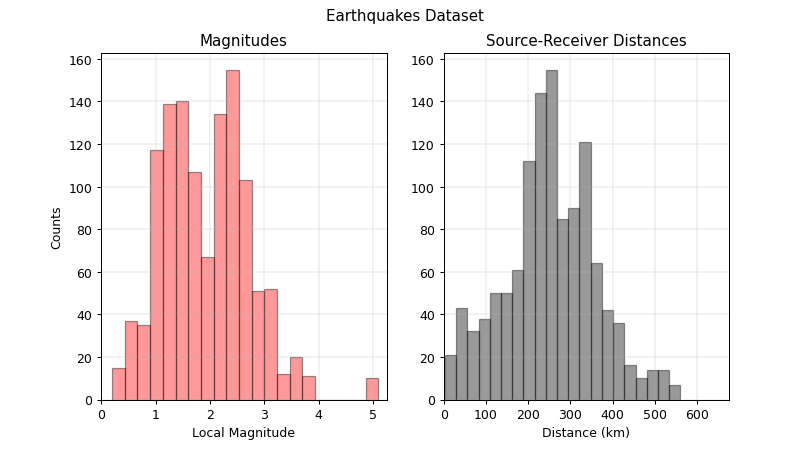

In [5]:
%matplotlib notebook
# Plotting earthquakes histogram
mags_xlim = [0,5.25]; dists_xlim = [0,675]
bins_mags, bins_dists = KGN.plot_hist([metadata_eq[:,5].astype(float)], [metadata_eq[:,6].astype(float)], return_bins=True, mags_xlim=mags_xlim, dists_xlim=dists_xlim, title='Earthquakes Dataset')

---
#### Explosions

<IPython.core.display.Javascript object>


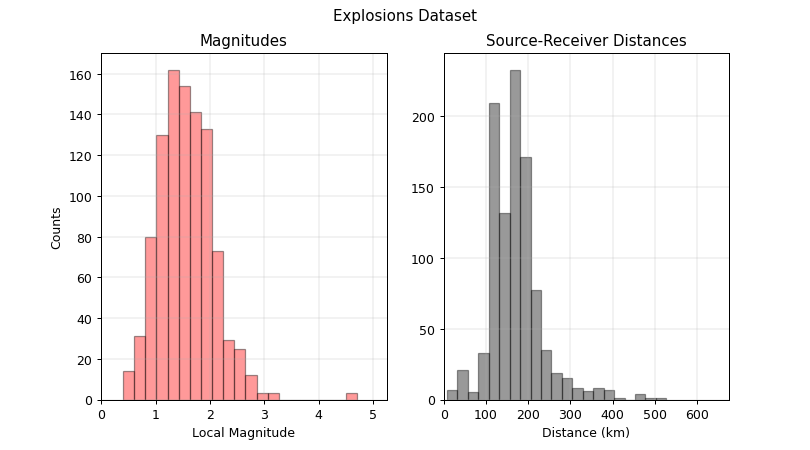

In [6]:
%matplotlib notebook
# Plotting
KGN.plot_hist([metadata_exp[:,5].astype(float)], [metadata_exp[:,6].astype(float)], bins_mags=bins_mags, bins_dists=bins_dists, mags_xlim=mags_xlim, dists_xlim=dists_xlim, title='Explosions Dataset')

## Generating map of events used in the study
---

<IPython.core.display.Javascript object>


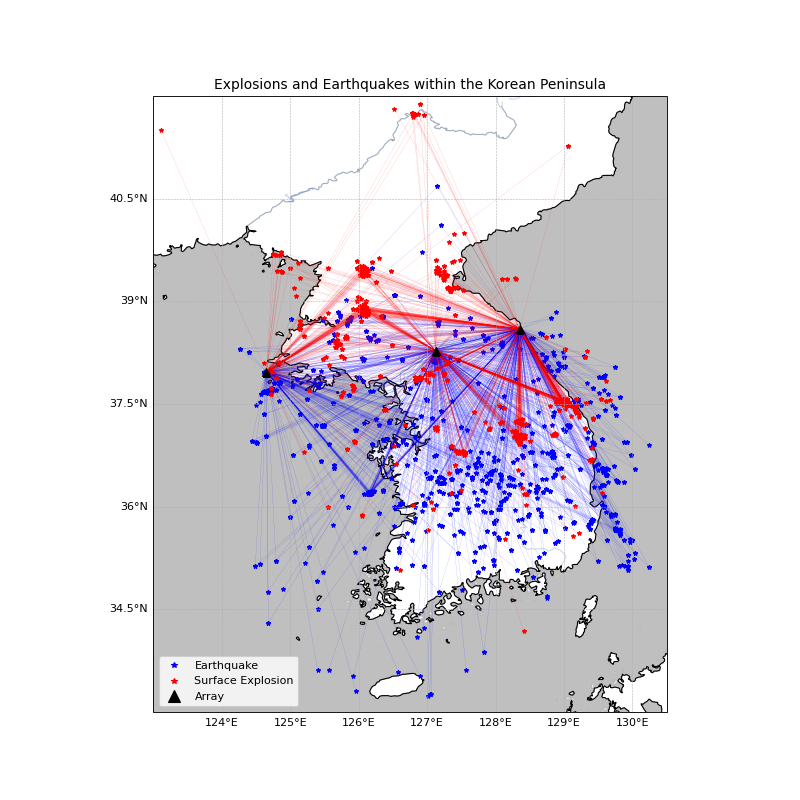

In [5]:
%matplotlib notebook
KGN.generate_map(metadata_eq[:,3].astype(float), metadata_eq[:,4].astype(float), metadata_exp[:,3].astype(float), metadata_exp[:,4].astype(float), eq_arrays=metadata_eq[:,1], exp_arrays=metadata_exp[:,1],
                 markersize=4, array_markersize=8, figsize=(10,10), extent=[123, 130.5, 42, 33], lw=0.1, title_size=12.5, legend_fontsize=10, markerscale=1.25)